In [2]:
import numpy as np
from scipy.stats import ortho_group  # Requires version 0.18 of scipy
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import rie_estimator
from pyRMT import optimalShrinkage

# I - Introduction

# II - Definition and detection of the problem

## 1 - Create a random correlation Matrix with specific eigen values

In [3]:
# normalization of the eigenvalues to have a trace(Matrix) = n, with n is the  size of the matrix ()
#  => because the correlation matrix trace remains invariant by the diagonalization

def normalaized_eigenvalues (input_eigenvalues):
    n = len(input_eigenvalues)
    return  n * input_eigenvalues / np.sum(input_eigenvalues)

# generate a random symmetric matrix with specific eigenvalues
def generate_wge(eigenvalues):
    n = len(eigenvalues)
    ortho_matrix = ortho_group.rvs(dim=n)
    diag_matrix = np.diag(eigenvalues)
    return ortho_matrix.T.dot(diag_matrix).dot(ortho_matrix)

# Givens rotation,it will be used to transform the matrix in generate_corr_wse function, to have 1's in diagonal

def givens(M, i, j):
    G = M
    Mii, Mij, Mjj = M[i,i], M[i,j], M[j,j]
    t = (Mij + np.sqrt(Mij**2 - (Mii-1)*(Mjj-1))) /(Mjj - 1)
    c = 1. / np.sqrt(1+t**2)
    s = c*t
    Mi, Mj = M[i], M[j]
    G[i], G[j] = c*Mi - s*Mj, s*Mi + c*Mj
    Mi, Mj = G[:,i], G[:,j]
    G[:,i], G[:,j] = c*Mi - s*Mj, s*Mi + c*Mj
    return G
    
def generate_corr_wse(eigs):
    n = len(eigs)
    eigen = normalaized_eigenvalues (eigs)
    corr = generate_wge(eigen)
    precision = 0.01
    converg = 0
    i = 0
    while(not converg):
        vec = np.diagonal(corr)
        if np.sum(abs(vec-1)>precision)==0:
            converg = 1
        else:
            bigger = np.arange(len(vec))[(vec>1)]
            smaller = np.arange(len(vec))[(vec<1)]
            i,j = smaller[0], bigger[-1]
            if i>j:
                i,j = bigger[0], smaller[-1]
            corr = givens(corr, i, j)
            corr[i,i]=1
    return corr
def get_random_eigen_values (min,max,size):
     return np.random.randint(min,max,size)

## 2- Some Tests 

In [4]:
# Generate a symmetric matrix with specific eigen values
a = generate_wge([1,2,3])
a

array([[ 2.05850719,  0.7909604 , -0.36006826],
       [ 0.7909604 ,  2.33485488,  0.3310441 ],
       [-0.36006826,  0.3310441 ,  1.60663793]])

In [5]:
# diagonalized matrix
LA.eig(a)[0]

array([1., 3., 2.])

In [6]:
a = generate_corr_wse(np.array([5,4,3]))

In [7]:
LA.eig(a)[0]

array([1.25, 0.75, 1.  ])

In [8]:
generate_wge([1,2,3])

array([[ 1.68122106,  0.59360911, -0.34110005],
       [ 0.59360911,  2.66391737,  0.44778965],
       [-0.34110005,  0.44778965,  1.65486158]])

In [9]:
a = generate_corr_wse(np.array([5,4,3]))
a

array([[ 1.00000000e+00, -2.22044605e-16, -9.15495855e-02],
       [-2.15105711e-16,  1.00000000e+00, -2.32634205e-01],
       [-9.15495855e-02, -2.32634205e-01,  1.00000000e+00]])

In [10]:
generate_corr_wse(get_random_eigen_values (0,10,3))

array([[ 1.        ,  0.04684276, -0.12600204],
       [ 0.04684276,  1.        , -0.15911528],
       [-0.12600204, -0.15911528,  1.        ]])

## 3- Simalting Data from a correlation Matrix 

In [11]:
def generate_data (correlation_matrix , ration_q):
    
    # q = variables / observations
    num_variables = correlation_matrix.shape[0]
    
    num_samples = int(num_variables//q)
    # starting with mean = 0 
    mu = np.zeros(num_variables)
    y = np.random.multivariate_normal(mu, correlation_matrix, size=num_samples)
    df = pd.DataFrame(y)
    return df
def get_data_sample(data, q):
    return data.sample(int(data.shape[1]//q))

## 4-reproduction of the problem for a Dataframe with 180 variables with different values of q

In [12]:
Number_variables = 180
q = 0.1
eigen_values = normalaized_eigenvalues(get_random_eigen_values (0,10,Number_variables))
r = generate_corr_wse(eigen_values)

In [13]:
data = generate_data (r , 0.001)

In [14]:
data_01 = get_data_sample(data, 0.1) # q = 0.1
data_1 = get_data_sample(data, 1)   # q = 1
data_2 = get_data_sample(data, 2)   # q = 2 

In [15]:
# comuting spectrum for different samples 

x =  np.array(range(1, Number_variables+1))

spectrum =  LA.eig(data.corr().to_numpy())[0]
spectrum.sort()
spectrum = spectrum[::-1]

spectrum_01 =  LA.eig(data_01.corr().to_numpy())[0]
spectrum_01.sort()
spectrum_01 = spectrum_01[::-1]

spectrum_1 =  LA.eig(data_1.corr().to_numpy())[0]
spectrum_1.sort()
spectrum_1 = spectrum_1[::-1]

spectrum_2 =  LA.eig(data_2.corr().to_numpy())[0]
spectrum_2.sort()
spectrum_2 = spectrum_2[::-1]


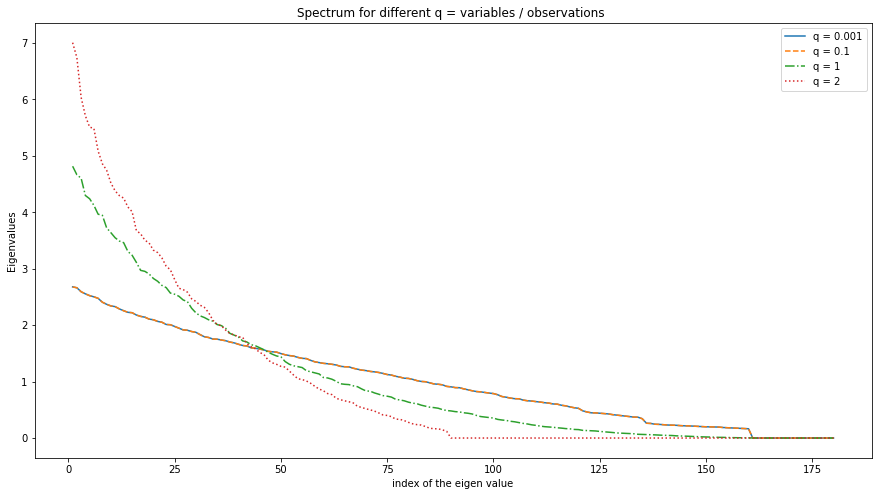

In [32]:
plt.figure(figsize=(15,8))
plt.plot(x, spectrum, linestyle='-',label = 'q = 0.001')  
plt.plot(x, spectrum_01, linestyle='--',label = 'q = 0.1')  
plt.plot(x, spectrum_1, linestyle='-.',label = 'q = 1')  
plt.plot(x, spectrum_2, linestyle=':',label = 'q = 2')  

plt.title("Spectrum for different q = variables / observations ")
plt.xlabel("index of the eigen value")
plt.ylabel("Eigenvalues")

plt.legend()

<mark>Problem well detected !!  => overestimation for the largest eigenvalues, and underetismations for the smallest eigenvalues<mark> 

# III-Models

## 1- Optimal Rotational Invariant Estimator (RIE)

We have indeed noticed a deformation of the  the correlation matrices spectrum in the case where the number of observations is equal  or less than the number of variables, which corresponds to a q > 1, the larger the q, the greater the deformation becomes.  
the RIE estimator aims to correct the correlation matrix and therefore correct its spectrum. we will apply this on the 4 databases generated previously with different q and we will see the result.

In [21]:
#Calculate the RIE estimator to clean correlation matrix
data_cleaned_matrix_rie = rie_estimator.get_rie(data, normalize = True, max_ones = True)
data_01_cleaned_matrix_rie = rie_estimator.get_rie(data_01, normalize = True, max_ones = True)
data_1_cleaned_matrix_rie = rie_estimator.get_rie(data_1, normalize = True, max_ones = True)
data_2_cleaned_matrix_rie = rie_estimator.get_rie(data_2, normalize = True, max_ones = True)

In [24]:
#calculate matrix spectra
spectrum_cleaned_rie =  LA.eig(data_cleaned_matrix_rie)[0]
spectrum_cleaned_rie.sort()
spectrum_cleaned_rie = spectrum_cleaned_rie[::-1]

spectrum_01_cleaned_rie =  LA.eig(data_01_cleaned_matrix_rie)[0]
spectrum_01_cleaned_rie.sort()
spectrum_01_cleaned_rie = spectrum_01_cleaned_rie[::-1]

spectrum_1_cleaned_rie =  LA.eig(data_1_cleaned_matrix_rie)[0]
spectrum_1_cleaned_rie.sort()
spectrum_1_cleaned_rie = spectrum_1_cleaned_rie[::-1]

spectrum_2_cleaned_rie =  LA.eig(data_2_cleaned_matrix_rie)[0]
spectrum_2_cleaned_rie.sort()
spectrum_2_cleaned_rie= spectrum_2_cleaned_rie[::-1]

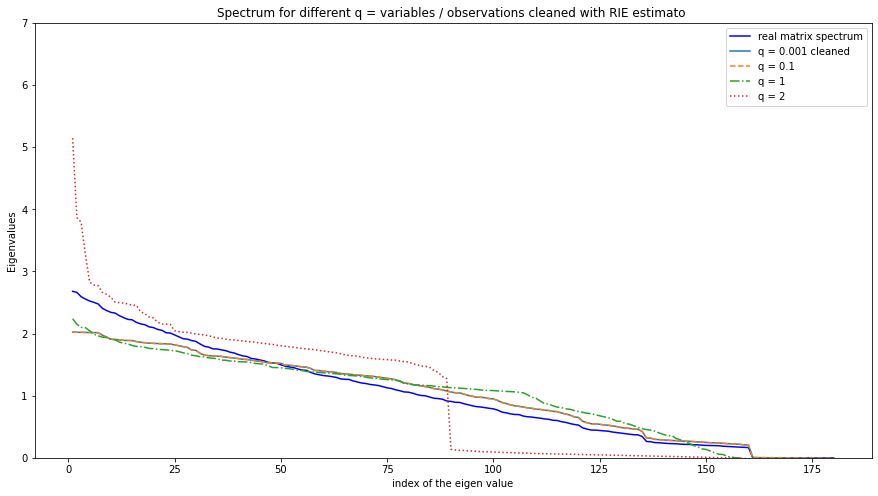

In [31]:
#plot corrected matrix spectra
plt.figure(figsize=(15,8))

plt.plot(x, spectrum, linestyle='-', color ='blue',label = 'real matrix spectrum')  
plt.plot(x, spectrum_cleaned_rie, linestyle='-',label = 'q = 0.001 cleaned ')  
plt.plot(x, spectrum_01_cleaned_rie, linestyle='--',label = 'q = 0.1')  
plt.plot(x, spectrum_1_cleaned_rie, linestyle='-.',label = 'q = 1')  
plt.plot(x, spectrum_2_cleaned_rie, linestyle=':',label = 'q = 2')  

plt.title("Spectrum for different q = variables / observations cleaned with RIE estimato ")
plt.xlabel("index of the eigen value")
plt.ylabel("Eigenvalues")

plt.ylim(0,7)
plt.legend()